# LSTM Video Classification

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras import optimizers
from keras.layers import TimeDistributed
from time import time
from keras.callbacks import TensorBoard
import librosa
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import dlib
import cv2
from imutils import face_utils

In [2]:
SHAPE_PREDICTOR_LOCATION = "./shape_predictor_68_face_landmarks.dat"
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(SHAPE_PREDICTOR_LOCATION)

def process_Video(video):
    #print("================================")
    X = []
    Y = []
    cap = cv2.VideoCapture(video)
    fps = cap.get(cv2.CAP_PROP_FPS)
    #print("FPS : " + str(fps))
    if(not cap.isOpened()):
        print(" .....Cannot open video stream or file!.....")
    #print(" video/camera opened...")
    #print("********************************************")
    while(cap.isOpened()):
        frameId = cap.get(1)
        try:
            ret, image = cap.read()
            if(ret==False):
                break
            else:
                if int(frameId)<30:
                    #print("Frame ID :"+ str(frameId))
                    #image = imutils.rotate_bound(image,angle=90)
                    #image = imutils.resize(image,width = 500)
                    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                    #cv2.imshow("gray",image)
                    faces = face_detector(gray_image,1)
                    for (i,rect) in enumerate(faces):
                        shape = shape_predictor(gray_image,rect)
                        shape = face_utils.shape_to_np(shape)

                        for (name, (i,j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
                            if(name=='mouth'):
                                #cpyImage = image.copy()
                                X_frame = []
                                Y_frame = []
                                for (x,y) in   shape[i:j]:
                                    X_frame.append(x)
                                    Y_frame.append(y)
                        X.append(X_frame)
                        Y.append(Y_frame)
                                # (x,y,w,h) = cv2.boundingRect(np.array(shape[i:j]))
                                # roi = imutils.resize(cpyImage[y:y+h,x:x+w],width=250,inter=cv2.INTER_CUBIC)
                                # cv2.imshow("Image",roi)

                        #print("================================================")
            # if(cv2.waitKey(1) & 0XFF == ord('q')):
            #                             print("........... Stopping..........")

            #                             break;
        except Exception as e:
            print("ERROR OCCURED......." + e)
            break;
    cap.release()
    cv2.destroyAllWindows()
    return X,Y

In [3]:
def process_Arrays(X,Y):
    X = pd.DataFrame(X)
    Y = pd.DataFrame(Y)
    X_first_row = X.iloc[[0]].values[0]
    #print(X_first_row)
    Y_first_row = Y.iloc[[0]].values[0]
    #X.iloc[1:].apply(lambda x: np.sqrt(sum((row1-x)**2)), axis=1).values
    X=X.apply(lambda row: row - X_first_row, axis=1)
    Y=Y.apply(lambda row: row - Y_first_row, axis=1)
#     print(X)
#     print(Y)
    Z = pd.concat([X,Y],axis=1)
#     X_sd_array = np.std(X,axis = 0).astype('float32')
#     Y_sd_array = np.std(Y,axis = 0).astype('float32')
    Z=Z.values.tolist()
#    Y=Y.values.tolist()

    return Z

In [4]:
temp_dictionary = {}
TRAIN_DATA_LOCATION = "/media/vinay/Academy/Final_year_project/NEW_VIDEOS_AGAIN_DIVIDED_15_TEST_SIZE/Video_only/train"
train_audio_path = "/media/vinay/Academy/Final_year_project/NEW_VIDEOS_AGAIN_DIVIDED_15_TEST_SIZE/Audio_only/train"
label_dictionary = []
feature_vector=list()
X_train = []
X_train_audio = []
Y_train = []
i=0
for each_word in os.listdir(TRAIN_DATA_LOCATION):
    #i=0
    print("#########" + each_word + "##########")
    word_folder = os.path.join(TRAIN_DATA_LOCATION,each_word)
    label_dictionary.append(word_folder)
    #print("Current Directory  :" + word_folder )

    for each_video in os.listdir(word_folder):

        print("Processing video " + each_video)
        #print("Video count " + str(i))
#         samples, sample_rate = librosa.load(train_audio_path + '/' + each_word + '/' + each_video[:-3] + "wav", sr = 16000)
#         samples = librosa.resample(samples, sample_rate, 8000)

#         if(len(samples) != 8363):
#             continue
        X1, sample_rate = librosa.load(train_audio_path + '/' + each_word + '/' + each_video[:-3] + "wav", sr = 16000)
        stft = np.abs(librosa.stft(X1))
        mfccs = np.mean(librosa.feature.mfcc(y=X1, sr=sample_rate, n_mfcc=40).T,axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        mel = np.mean(librosa.feature.melspectrogram(X1, sr=sample_rate).T,axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X1),sr=sample_rate).T,axis=0)
        feature_array = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
        feature_vector_audio  = np.around(feature_array,decimals=3)
        X,Y = process_Video(os.path.join(word_folder,each_video))
        feature_vector = process_Arrays(X,Y)
        #feature_vector = np.r_[X,Y]
        feature_vector  = np.around(feature_vector,decimals=3)
        #feature_vector = np.concatenate((feature_vector,samples), axis = 0)
        #print(feature_vector)
        #print(feature_vector)
        #print(feature_vector.shape)
        X_train.append(feature_vector)
        print(len(feature_vector))
        X_train_audio.append(feature_vector_audio)
        Y_train.append(i)
#         temp_dictionary = dict(enumerate(feature_vector))
#         temp_dictionary.update({'label':label_dictionary[each_word]})

#         training_Dataframe = training_Dataframe.append(temp_dictionary, ignore_index=True)
#         training_Dataframe = training_Dataframe.astype({'label':'int32'})
#         print(training_Dataframe)
    i+=1
    #print(i)


#########About##########
Processing video 1_sec_menaka_eng_about_3.mp4


/home/vinay/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=262
  n_fft, y.shape[-1]


30
Processing video 1_sec_sooraj_eng_about_4.mp4
30
Processing video 1_sec_cbn_eng_about_1.mp4
30
Processing video 1_sec_cbn_eng_about_2.mp4
30
Processing video 1_sec_cbn_eng_about_3.mp4
30
Processing video 1_sec_cbn_eng_about_4.mp4
30
Processing video 1_sec_eam_eng_about_1.mp4
30
Processing video 1_sec_eam_eng_about_2.mp4
30
Processing video 1_sec_eam_eng_about_3.mp4
30
Processing video 1_sec_eam_eng_about_4.mp4
30
Processing video 1_sec_karthikeya_eng_about_1.mp4
30
Processing video 1_sec_karthikeya_eng_about_2.mp4
30
Processing video 1_sec_karthikeya_eng_about_3.mp4
30
Processing video 1_sec_karthikeya_eng_about_4.mp4
30
Processing video 1_sec_kashinath_eng_about_1.mp4
30
Processing video 1_sec_kashinath_eng_about_2.mp4
30
Processing video 1_sec_kashinath_eng_about_3.mp4
30
Processing video 1_sec_kashinath_eng_about_4.mp4
30
Processing video 1_sec_kmk_eng_about_1.mp4
30
Processing video 1_sec_kmk_eng_about_2.mp4
30
Processing video 1_sec_kmk_eng_about_3.mp4
30
Processing video 1_sec

/home/vinay/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=272
  n_fft, y.shape[-1]


30
Processing video 19.mp4
30
Processing video 2.mp4
30
Processing video 21.mp4
30
Processing video 22.mp4
30
Processing video 23.mp4
30
Processing video 24.mp4
30
Processing video 26.mp4
30
Processing video 27.mp4
30
Processing video 28.mp4
30
Processing video 29.mp4
30
Processing video 3.mp4
30
Processing video 31.mp4
30
Processing video 32.mp4
30
Processing video 33.mp4
30
Processing video 34.mp4
30
Processing video 36.mp4
30
Processing video 37.mp4
30
Processing video 38.mp4
30
Processing video 39.mp4
30
Processing video 4.mp4
30
Processing video 41.mp4
30
Processing video 42.mp4
30
Processing video 43.mp4
30
Processing video 44.mp4
30
Processing video 46.mp4
30
Processing video 47.mp4
30
Processing video 48.mp4
30
Processing video 51.mp4
30
Processing video 52.mp4
30
Processing video 53.mp4
30
Processing video 54.mp4
30
Processing video 56.mp4
30
Processing video 57.mp4
30
Processing video 58.mp4
30
Processing video 59.mp4
30
Processing video 6.mp4
30
Processing video 61.mp4
30
Pr

31
Processing video 1_sec_poornima_eng_people_1_1.mp4
30
Processing video 1_sec_poornima_eng_people_1_2.mp4
30
Processing video 1_sec_poornima_eng_people_1_3.mp4
30
Processing video 1_sec_poornima_eng_people_1_4.mp4
30
Processing video 1_sec_ramya_eng_people_1_1.mp4
30
Processing video 1_sec_ramya_eng_people_1_2.mp4
30
Processing video 1_sec_ramya_eng_people_1_3.mp4
30
Processing video 1_sec_ramya_eng_people_1_4.mp4
30
Processing video 1_sec_sooraj_eng_people_1_1.mp4
30
Processing video 1_sec_sooraj_eng_people_1_2.mp4
30
Processing video 1_sec_sooraj_eng_people_1_3.mp4
30
Processing video 1_sec_sooraj_eng_people_1_4.mp4
30
Processing video 1_sec_spoorthi_eng_people_1_1.mp4
30
Processing video 1_sec_spoorthi_eng_people_1_2.mp4
30
Processing video 1_sec_madusudhan_eng_people_2_3.mp4
30
Processing video 1_sec_madusudhan_eng_people_2_4.mp4
30
Processing video 1_sec_mahesh_eng_people_1_1.mp4
30
Processing video 1_sec_mahesh_eng_people_1_2.mp4
30
Processing video 1_sec_mahesh_eng_people_1_3.

In [5]:
temp_dictionary1 = {}
TEST_DATA_LOCATION = "/media/vinay/Academy/Final_year_project/NEW_VIDEOS_AGAIN_DIVIDED_15_TEST_SIZE/Video_only/test"
test_audio_path = "/media/vinay/Academy/Final_year_project/NEW_VIDEOS_AGAIN_DIVIDED_15_TEST_SIZE/Audio_only/test"
#label_dictionary = []
feature_vector1=list()
X_test = []
X_test_audio = []
Y_test = []
i=0
for each_word in os.listdir(TEST_DATA_LOCATION):
    #i=0
    print("#########" + each_word + "##########")
    word_folder = os.path.join(TEST_DATA_LOCATION,each_word)
    #label_dictionary.append(word_folder)
    #print("Current Directory  :" + word_folder )

    for each_video in os.listdir(word_folder):

        print("Processing video " + each_video)
        #print("Video count " + str(i))
#         samples, sample_rate = librosa.load(train_audio_path + '/' + each_word + '/' + each_video[:-3] + "wav", sr = 16000)
#         samples = librosa.resample(samples, sample_rate, 8000)

#         if(len(samples) != 8363):
#             continue
        X1, sample_rate = librosa.load(test_audio_path + '/' + each_word + '/' + each_video[:-3] + "wav", sr = 16000)
        stft = np.abs(librosa.stft(X1))
        mfccs = np.mean(librosa.feature.mfcc(y=X1, sr=sample_rate, n_mfcc=40).T,axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        mel = np.mean(librosa.feature.melspectrogram(X1, sr=sample_rate).T,axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X1),sr=sample_rate).T,axis=0)
        feature_array = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
        feature_vector_audio  = np.around(feature_array,decimals=3)
        X,Y = process_Video(os.path.join(word_folder,each_video))
        feature_vector1 = process_Arrays(X,Y)
        #feature_vector = np.r_[X,Y]
        feature_vector1  = np.around(feature_vector1,decimals=3)
        #feature_vector = np.concatenate((feature_vector,samples), axis = 0)
        #print(feature_vector)
        #print(feature_vector)
        #print(feature_vector.shape)
        X_test.append(feature_vector1)
        X_test_audio.append(feature_vector_audio)
        Y_test.append(i)
        print(len(feature_vector1))
#         temp_dictionary = dict(enumerate(feature_vector))
#         temp_dictionary.update({'label':label_dictionary[each_word]})

#         training_Dataframe = training_Dataframe.append(temp_dictionary, ignore_index=True)
#         training_Dataframe = training_Dataframe.astype({'label':'int32'})
#         print(training_Dataframe)
    i+=1
    #print(i)


#########About##########
Processing video 1_sec_cbn_eng_about_5.mp4
30
Processing video 1_sec_eam_eng_about_5.mp4
30
Processing video 1_sec_karthikeya_eng_about_5.mp4
30
Processing video 1_sec_kashinath_eng_about_5.mp4
30
Processing video 1_sec_kmk_eng_about_5.mp4
30
Processing video 1_sec_madhusudan_eng_about_5.mp4
30
Processing video 1_sec_menaka_eng_about_5.mp4
30
Processing video 1_sec_pavankumar_eng_about_5.mp4
30
Processing video 1_sec_poornima_eng_about_5.mp4
30
Processing video 1_sec_ramya_eng_about_5.mp4
30
Processing video 1_sec_sooraj_eng_about_5.mp4
30
Processing video 1_sec_spoorthi_eng_about_5.mp4
30
Processing video 1_sec_sriharsha_eng_about_5.mp4
30
Processing video 1_sec_supritha_eng_about_5.mp4
30
Processing video 1_sec_tejas_eng_about_5.mp4
30
#########bottle##########
Processing video 1_sec_cbn_eng_bottle_4_4.mp4
30
Processing video 1_sec_cbn_eng_bottle_4_5.mp4
30
Processing video 1_sec_hardhuk_eng_bottle_2_5.mp4
30
Processing video 1_sec_karthikeya_eng_bottle_2_5.m

In [6]:
import dill
dill.dump_session('english_again_7words.db')

In [8]:
for i in range(0,425):
    #print(x_train_dup1[i].shape)
    a = len(X_train[i])
    if a != 30:
        print(len(X_train[i]),i)

34 170
34 171
36 172
31 334


In [15]:
for i in range(0,105):
    #print(x_train_dup1[i].shape)
    a = len(X_test[i])
    if a != 30:
        print(len(X_test[i]),i)

36 44
31 89


In [31]:
X_train_dup1 = X_train[0:170]
X_train_170 = X_train[170][0:30]
X_train_171 = X_train[171][0:30]
X_train_172 = X_train[172][0:30]
X_train_dup1.append(X_train_170)
X_train_dup1.append(X_train_171)
X_train_dup1.append(X_train_172)
for i in range(173,334):
    X_train_dup1.append(X_train[i])
X_train_334 = X_train[334][0:30]
X_train_dup1.append(X_train_334)
for i in range(335,425):
    X_train_dup1.append(X_train[i])

In [33]:
X_test_dup1 = X_test[0:44]
X_test_44 = X_test[44][0:30]
X_test_dup1.append(X_test_44)
for i in range(45,89):
    X_test_dup1.append(X_test[i])
X_test_89 = X_test[89][0:30]
X_test_dup1.append(X_test_89)
for i in range(90,105):
    X_test_dup1.append(X_test[i])

In [32]:
X_train_array = np.array(X_train_dup1)
X_train_array.shape

(425, 30, 40)

In [34]:
X_test_array = np.array(X_test_dup1)
X_test_array.shape

(105, 30, 40)

In [37]:
X_train_audio_array = np.array(X_train_audio)
print(X_train_audio_array.shape)
X_test_audio_array = np.array(X_test_audio)
print(X_test_audio_array.shape)

(425, 193)
(105, 193)


In [38]:
Y_train_array = np.array(Y_train)
Y_test_array = np.array(Y_test)
print(Y_train_array.shape)
print(Y_test_array.shape)

(425,)
(105,)


In [467]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
Y_train_array = lb_make.fit_transform(Y_train_array)
Y_test_array = lb_make.fit_transform(Y_test_array)

In [39]:
from keras.utils import to_categorical

Y_train_array = to_categorical(Y_train_array)
Y_test_array = to_categorical(Y_test_array)
print(Y_train_array.shape)
print(Y_test_array.shape)

(425, 7)
(105, 7)


In [372]:
from keras.layers.normalization import BatchNormalization
#callbacks1 = [callbacks11,callbacks21]
model1 = Sequential()

model1.add(LSTM(8,input_shape=(30,40),return_sequences=True,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(LSTM(64,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.275))
#model1.add(Dense(512))
#model1.add(Dropout(0.3))
model1.add(Dense(512))
model1.add(BatchNormalization())
model1.add(Dropout(0.275))
model1.add(Dense(256))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(64))
model1.add(BatchNormalization())
model1.add(Dense(7,activation='softmax'))

In [373]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [374]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 30, 8)             1568      
_________________________________________________________________
batch_normalization_205 (Bat (None, 30, 8)             32        
_________________________________________________________________
dropout_149 (Dropout)        (None, 30, 8)             0         
_________________________________________________________________
lstm_95 (LSTM)               (None, 64)                18688     
_________________________________________________________________
batch_normalization_206 (Bat (None, 64)                256       
_________________________________________________________________
dropout_150 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_186 (Dense)            (None, 512)             

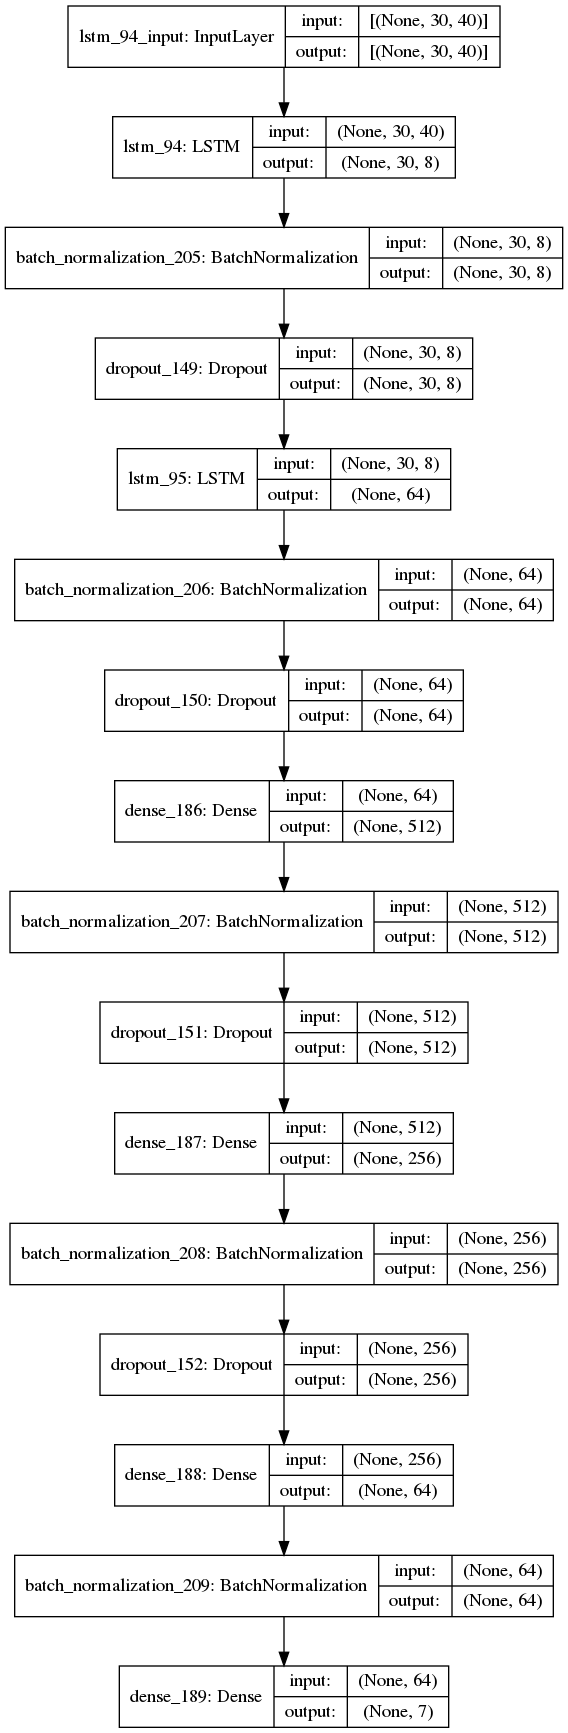

In [375]:
from keras.utils import plot_model
plot_model(model1, to_file='Video_model_plot_English_7words.png', show_shapes=True, show_layer_names=True)

In [376]:
history1 = model1.fit(X_train_array,Y_train_array,validation_data=(X_test_array,Y_test_array),epochs=125,callbacks=[tensorboard])

Epoch 1/125
14/14 [==============================] - 5s 109ms/step - loss: 2.5395 - accuracy: 0.1767 - val_loss: 2.0752 - val_accuracy: 0.1905
Epoch 2/125
14/14 [==============================] - 0s 23ms/step - loss: 2.0131 - accuracy: 0.2222 - val_loss: 2.2592 - val_accuracy: 0.1905
Epoch 3/125
14/14 [==============================] - 0s 23ms/step - loss: 2.0321 - accuracy: 0.2327 - val_loss: 2.0987 - val_accuracy: 0.1714
Epoch 4/125
14/14 [==============================] - 0s 23ms/step - loss: 1.9071 - accuracy: 0.2599 - val_loss: 1.8551 - val_accuracy: 0.2381
Epoch 5/125
14/14 [==============================] - 0s 24ms/step - loss: 1.8855 - accuracy: 0.2755 - val_loss: 1.8882 - val_accuracy: 0.2762
Epoch 6/125
14/14 [==============================] - 0s 24ms/step - loss: 1.7409 - accuracy: 0.3161 - val_loss: 1.9369 - val_accuracy: 0.2381
Epoch 7/125
14/14 [==============================] - 0s 24ms/step - loss: 1.7867 - accuracy: 0.3333 - val_loss: 1.8616 - val_accuracy: 0.2762
Epoch

14/14 [==============================] - 0s 22ms/step - loss: 0.7781 - accuracy: 0.7578 - val_loss: 1.2788 - val_accuracy: 0.5333
Epoch 59/125
14/14 [==============================] - 0s 23ms/step - loss: 0.8042 - accuracy: 0.7334 - val_loss: 1.2516 - val_accuracy: 0.5619
Epoch 60/125
14/14 [==============================] - 0s 22ms/step - loss: 0.9328 - accuracy: 0.6720 - val_loss: 1.2133 - val_accuracy: 0.5524
Epoch 61/125
14/14 [==============================] - 0s 22ms/step - loss: 0.8789 - accuracy: 0.6977 - val_loss: 1.1062 - val_accuracy: 0.5619
Epoch 62/125
14/14 [==============================] - 0s 22ms/step - loss: 0.8770 - accuracy: 0.6901 - val_loss: 1.1582 - val_accuracy: 0.5714
Epoch 63/125
14/14 [==============================] - 0s 22ms/step - loss: 0.9026 - accuracy: 0.6733 - val_loss: 1.1190 - val_accuracy: 0.5619
Epoch 64/125
14/14 [==============================] - 0s 22ms/step - loss: 0.9103 - accuracy: 0.7135 - val_loss: 1.1328 - val_accuracy: 0.5905
Epoch 65/125

14/14 [==============================] - 0s 24ms/step - loss: 0.5517 - accuracy: 0.8119 - val_loss: 1.2353 - val_accuracy: 0.5333
Epoch 116/125
14/14 [==============================] - 0s 24ms/step - loss: 0.5556 - accuracy: 0.7930 - val_loss: 1.1954 - val_accuracy: 0.5810
Epoch 117/125
14/14 [==============================] - 0s 25ms/step - loss: 0.5706 - accuracy: 0.7921 - val_loss: 1.0389 - val_accuracy: 0.6571
Epoch 118/125
14/14 [==============================] - 0s 24ms/step - loss: 0.4958 - accuracy: 0.8230 - val_loss: 1.1752 - val_accuracy: 0.6381
Epoch 119/125
14/14 [==============================] - 0s 22ms/step - loss: 0.5592 - accuracy: 0.7776 - val_loss: 0.9865 - val_accuracy: 0.7143
Epoch 120/125
14/14 [==============================] - 0s 25ms/step - loss: 0.4718 - accuracy: 0.8292 - val_loss: 1.0923 - val_accuracy: 0.6667
Epoch 121/125
14/14 [==============================] - 0s 23ms/step - loss: 0.6164 - accuracy: 0.7785 - val_loss: 1.0190 - val_accuracy: 0.6762
Epoch 

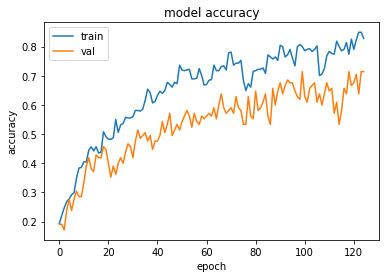

In [377]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Video_English Model_7words_accuracy.jpg')
plt.show()

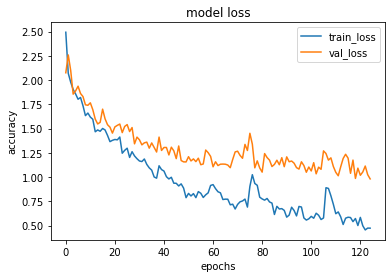

In [378]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.savefig('Video_English Model_7words_loss.jpg')
plt.show()

In [379]:
predict_prob1=model1.predict(X_test_array)
predict_classes1=np.argmax(predict_prob1,axis=1)
predict_classes1
score1, acc1 = model1.evaluate(X_test_array, Y_test_array)

4/4 [==============================] - 0s 6ms/step - loss: 0.9814 - accuracy: 0.7143


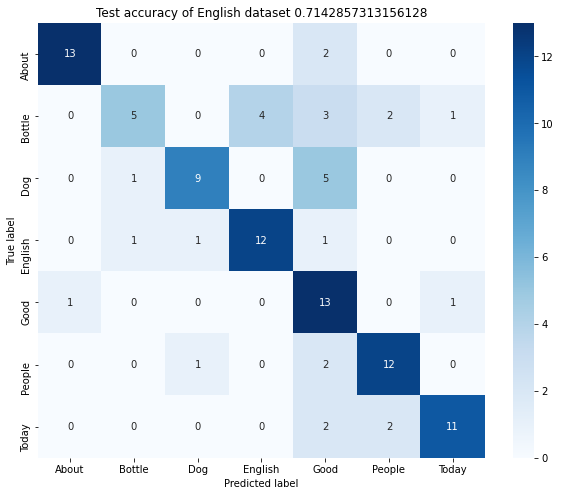

In [382]:
y_val1 = list()
for i in Y_test_array:
    count = 0
    for j in i:
        if( j == 1):
            y_val1.append(count);
        count +=1;

from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
words_list = ['About','Bottle', 'Dog','English', 'Good','People', 'Today']
lb = LabelEncoder()
y_pred1 = lb.fit_transform(predict_classes1)
Y_Test1 = lb.fit_transform(y_val1)
cm = confusion_matrix(Y_Test1, y_pred1)
cm_df = pd.DataFrame(cm,index =words_list,columns = words_list)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title('Test accuracy of English dataset {}'.format(acc1))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('Video_English_7words_Confusion Matrix.jpg')
plt.show()

In [384]:
from sklearn.metrics import classification_report
y_pred1 = lb.fit_transform(predict_classes1)
Y_Test1 = lb.fit_transform(Y_Test1)
print(classification_report(Y_Test1, y_pred1, target_names=words_list))

              precision    recall  f1-score   support

       About       0.93      0.87      0.90        15
      Bottle       0.71      0.33      0.45        15
         Dog       0.82      0.60      0.69        15
     English       0.75      0.80      0.77        15
        Good       0.46      0.87      0.60        15
      People       0.75      0.80      0.77        15
       Today       0.85      0.73      0.79        15

    accuracy                           0.71       105
   macro avg       0.75      0.71      0.71       105
weighted avg       0.75      0.71      0.71       105



In [119]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
model1.save('english_model_video_v1.h5')#creates a HDF5 file 'my_model_name.h5'


In [120]:
model_json = model1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [432]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, BatchNormalization, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

input_audio = Input(shape=(193,1))
input_video = Input(shape=(30,40))

conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(input_audio)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
conv = BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,beta_initializer="zeros",gamma_initializer="ones",moving_mean_initializer="zeros",moving_variance_initializer="ones",beta_regularizer=None,gamma_regularizer=None,beta_constraint=None,gamma_constraint=None,renorm=False,renorm_clipping=None,renorm_momentum=0.99,fused=None,trainable=True,virtual_batch_size=None, adjustment=None, name=None)(conv)
conv = Flatten()(conv)
x = Dense(units=512, activation='relu')(conv)
x1 = BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,beta_initializer="zeros",gamma_initializer="ones",moving_mean_initializer="zeros",moving_variance_initializer="ones",beta_regularizer=None,gamma_regularizer=None,beta_constraint=None,gamma_constraint=None,renorm=False,renorm_clipping=None,renorm_momentum=0.99,fused=None,trainable=True,virtual_batch_size=None, adjustment=None, name=None)(x)
x1 = Dropout(0.3)(x1)
x1 = Dense(256, activation='relu')(x1)
x1 = BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,beta_initializer="zeros",gamma_initializer="ones",moving_mean_initializer="zeros",moving_variance_initializer="ones",beta_regularizer=None,gamma_regularizer=None,beta_constraint=None,gamma_constraint=None,renorm=False,renorm_clipping=None,renorm_momentum=0.99,fused=None,trainable=True,virtual_batch_size=None, adjustment=None, name=None)(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,beta_initializer="zeros",gamma_initializer="ones",moving_mean_initializer="zeros",moving_variance_initializer="ones",beta_regularizer=None,gamma_regularizer=None,beta_constraint=None,gamma_constraint=None,renorm=False,renorm_clipping=None,renorm_momentum=0.99,fused=None,trainable=True,virtual_batch_size=None, adjustment=None, name=None)(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(8, activation='relu')(x1)

y = LSTM(128,input_shape=(30,40),return_sequences=True,activation='relu')(input_video)

#y = Dense(512, activation='relu')(y)
y1 = BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,beta_initializer="zeros",gamma_initializer="ones",moving_mean_initializer="zeros",moving_variance_initializer="ones",beta_regularizer=None,gamma_regularizer=None,beta_constraint=None,gamma_constraint=None,renorm=False,renorm_clipping=None,renorm_momentum=0.99,fused=None,trainable=True,virtual_batch_size=None, adjustment=None, name=None)(y)
y1 = Dropout(0.4)(y1)
y1 = LSTM(128,activation='relu')(y1)
y1 = BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,beta_initializer="zeros",gamma_initializer="ones",moving_mean_initializer="zeros",moving_variance_initializer="ones",beta_regularizer=None,gamma_regularizer=None,beta_constraint=None,gamma_constraint=None,renorm=False,renorm_clipping=None,renorm_momentum=0.99,fused=None,trainable=True,virtual_batch_size=None, adjustment=None, name=None)(y1)
y1 = Dropout(0.275)(y1)
y1 = Dense(512, activation='relu')(y1)

#y = Model(inputs=input_video, outputs=y)
y = Flatten()(y)
combined = Concatenate()([x, y])
z1 = Dense(512, activation="relu")(combined)
z1 = Dropout(0.3)(z1)
z1 = Dense(1024, activation="relu")(z1)
z1 = Dropout(0.3)(z1)
z1 = Dense(256, activation="relu")(z1)
combined1 = Concatenate()([x1, y1,z1]) 

z = Dense(512, activation="relu")(combined1)
z = Dropout(0.5)(z)
z = Dense(1024, activation="relu")(z)
z = Dropout(0.5)(z)
z = Dense(256, activation="relu")(z)


z = Dense(7, activation='softmax')(z)
model = Model(inputs=[input_audio, input_video], outputs=z)
#model = Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 193, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 181, 8)       112         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 60, 8)        0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 60, 8)        0           max_pooling1d[0][0]              
______________________________________________________________________________________________

In [433]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

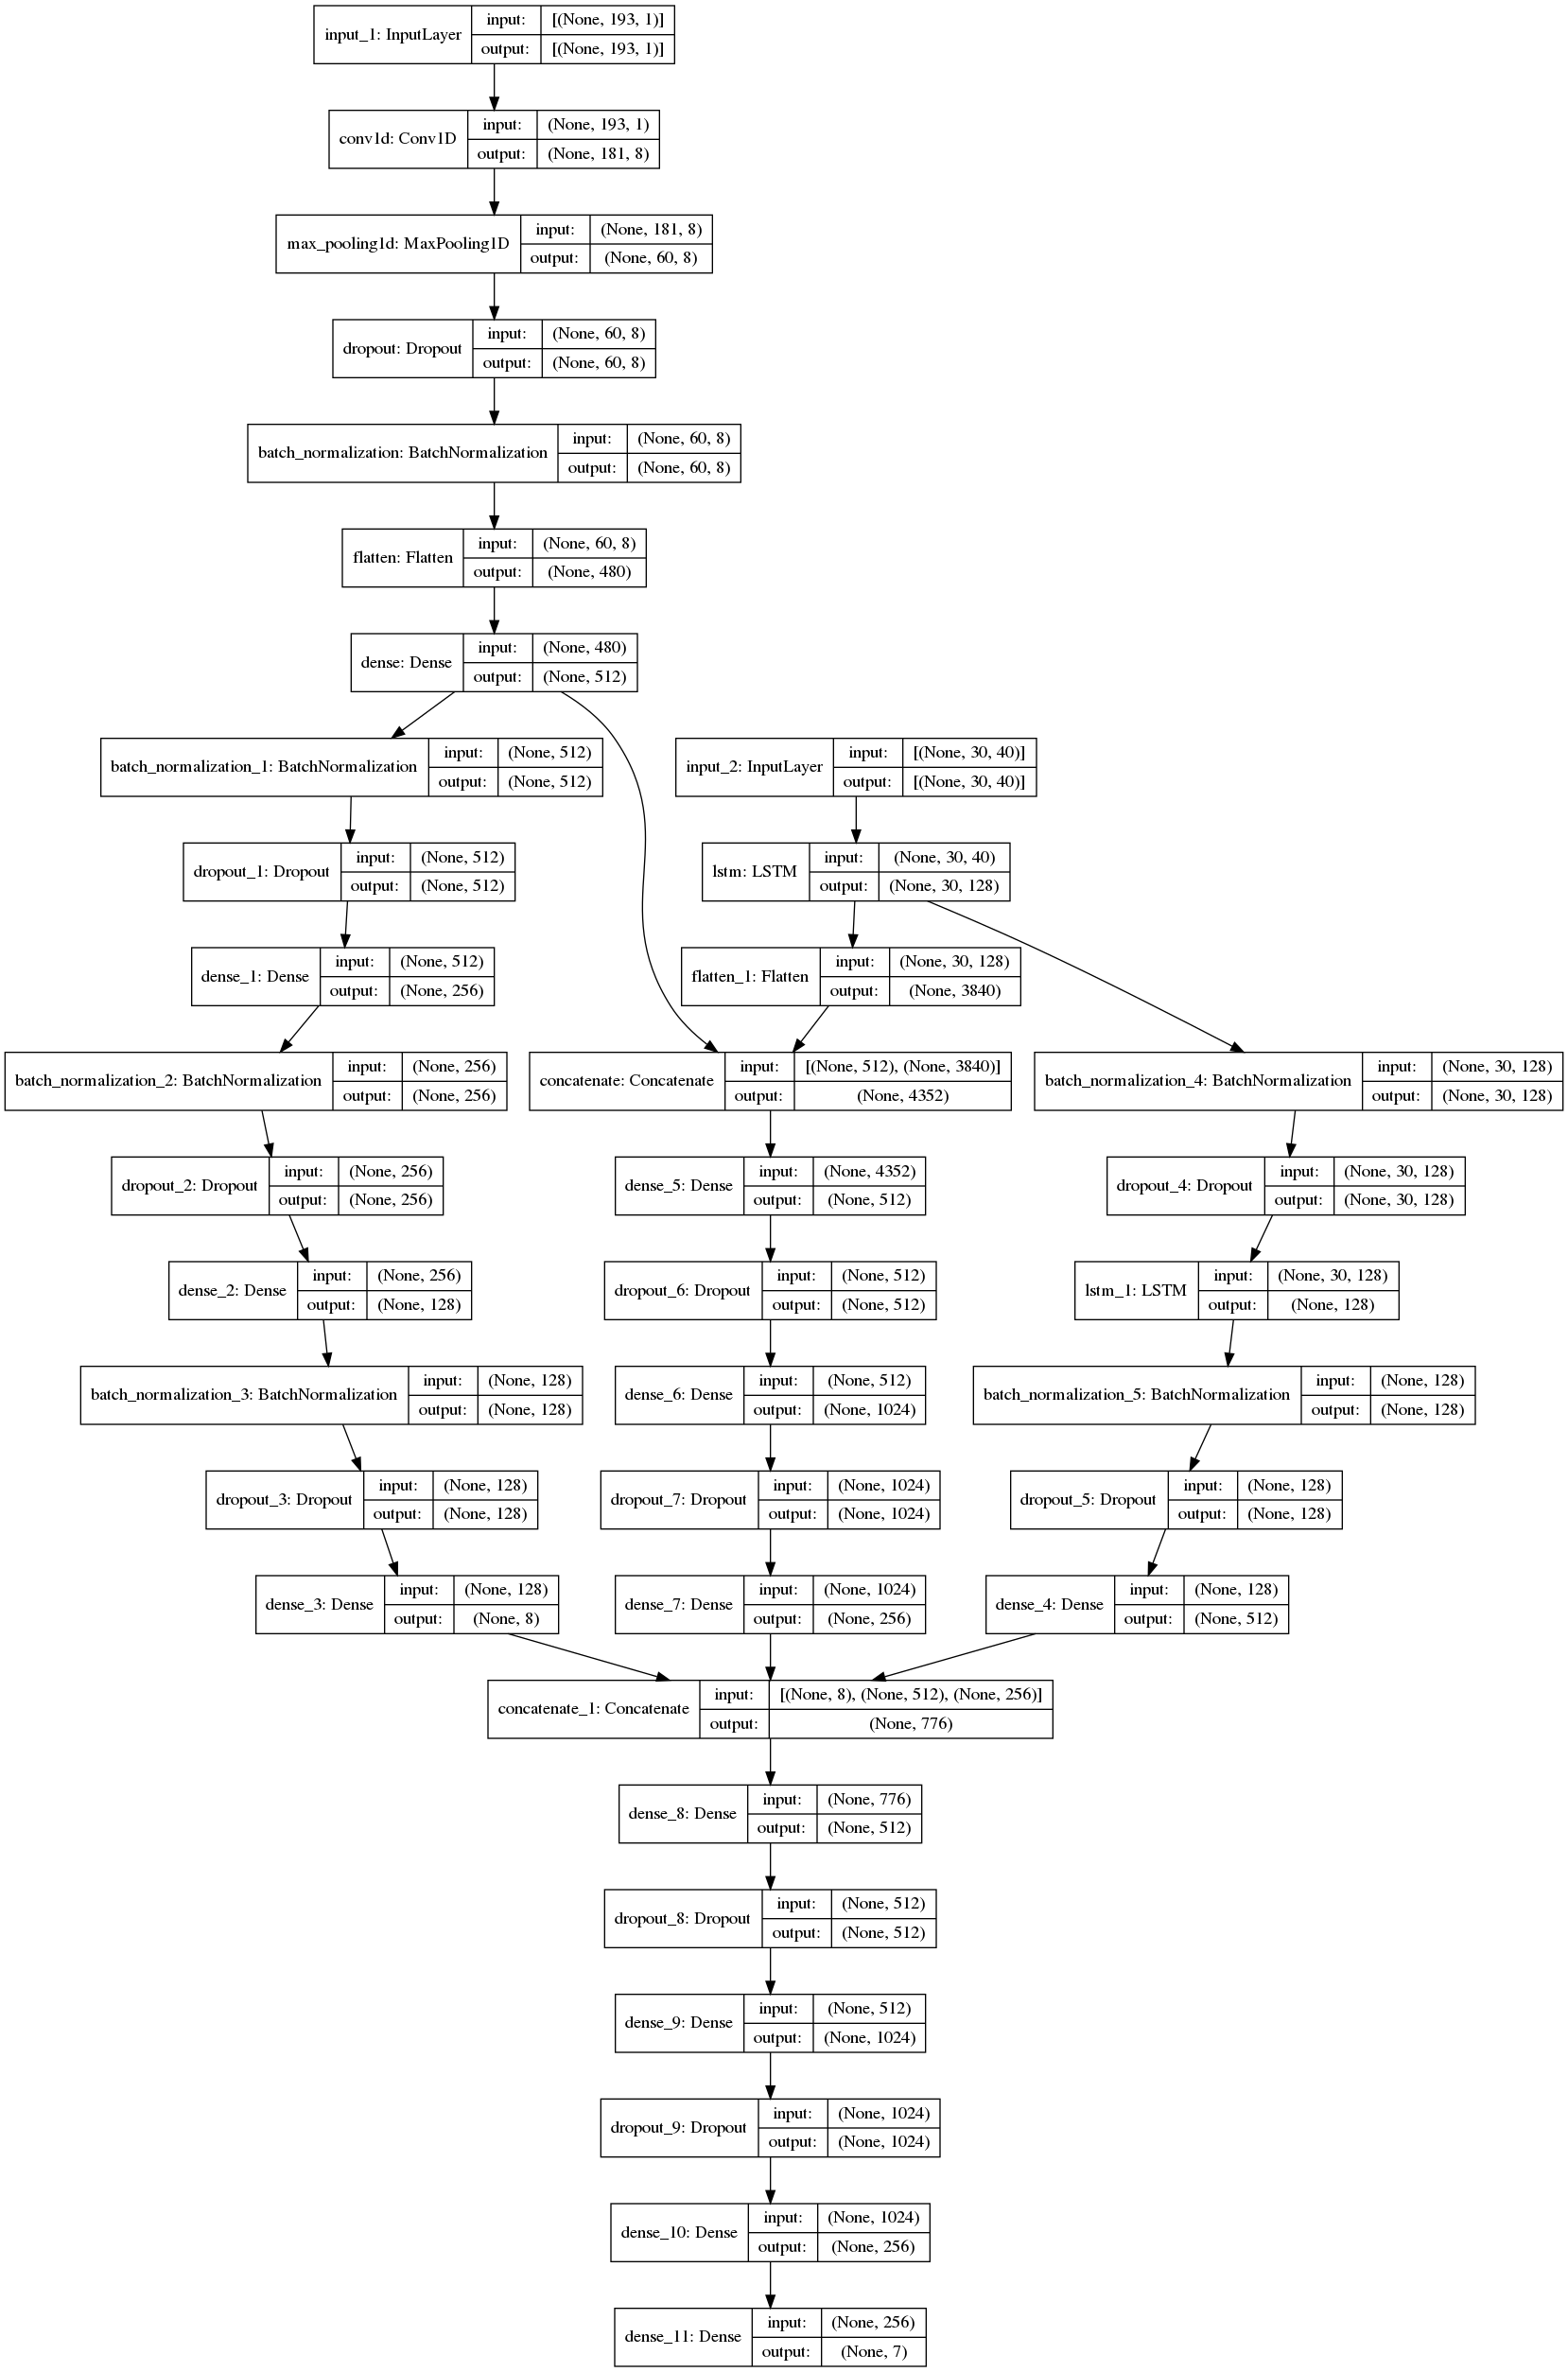

In [434]:
from keras.utils import plot_model
plot_model(model, to_file='AVSR_model_plot_eng_7words.png', show_shapes=True, show_layer_names=True)

In [435]:
history = model.fit(x=[X_train_audio_array, X_train_array], y=Y_train_array, batch_size=32, epochs=230, verbose=1, validation_data=([X_test_audio_array,X_test_array],Y_test_array))

Epoch 1/230
14/14 [==============================] - 6s 128ms/step - loss: 2.7402 - accuracy: 0.1099 - val_loss: 2.0825 - val_accuracy: 0.1429
Epoch 2/230
14/14 [==============================] - 1s 91ms/step - loss: 2.3442 - accuracy: 0.1626 - val_loss: 1.8693 - val_accuracy: 0.2476
Epoch 3/230
14/14 [==============================] - 1s 91ms/step - loss: 1.9775 - accuracy: 0.2435 - val_loss: 1.8100 - val_accuracy: 0.2667
Epoch 4/230
14/14 [==============================] - 1s 90ms/step - loss: 2.0019 - accuracy: 0.2219 - val_loss: 1.9632 - val_accuracy: 0.3238
Epoch 5/230
14/14 [==============================] - 1s 93ms/step - loss: 2.0716 - accuracy: 0.2057 - val_loss: 1.7836 - val_accuracy: 0.2857
Epoch 6/230
14/14 [==============================] - 1s 91ms/step - loss: 1.7518 - accuracy: 0.2896 - val_loss: 1.6806 - val_accuracy: 0.3238
Epoch 7/230
14/14 [==============================] - 1s 93ms/step - loss: 1.6424 - accuracy: 0.3415 - val_loss: 1.5848 - val_accuracy: 0.3524
Epoch

14/14 [==============================] - 1s 97ms/step - loss: 0.4294 - accuracy: 0.8643 - val_loss: 0.7852 - val_accuracy: 0.7333
Epoch 59/230
14/14 [==============================] - 1s 96ms/step - loss: 0.4568 - accuracy: 0.8399 - val_loss: 0.6813 - val_accuracy: 0.7524
Epoch 60/230
14/14 [==============================] - 1s 96ms/step - loss: 0.4118 - accuracy: 0.8591 - val_loss: 0.7613 - val_accuracy: 0.7714
Epoch 61/230
14/14 [==============================] - 1s 97ms/step - loss: 0.3662 - accuracy: 0.8890 - val_loss: 0.7548 - val_accuracy: 0.7619
Epoch 62/230
14/14 [==============================] - 1s 95ms/step - loss: 0.3756 - accuracy: 0.8759 - val_loss: 0.8577 - val_accuracy: 0.7810
Epoch 63/230
14/14 [==============================] - 1s 96ms/step - loss: 0.3759 - accuracy: 0.8744 - val_loss: 0.9160 - val_accuracy: 0.7143
Epoch 64/230
14/14 [==============================] - 1s 96ms/step - loss: 0.4176 - accuracy: 0.8881 - val_loss: 1.0685 - val_accuracy: 0.6952
Epoch 65/230

14/14 [==============================] - 1s 95ms/step - loss: 0.6456 - accuracy: 0.7564 - val_loss: 0.6413 - val_accuracy: 0.7714
Epoch 116/230
14/14 [==============================] - 1s 96ms/step - loss: 0.7198 - accuracy: 0.7380 - val_loss: 0.7654 - val_accuracy: 0.7333
Epoch 117/230
14/14 [==============================] - 1s 95ms/step - loss: 0.7476 - accuracy: 0.7259 - val_loss: 0.6433 - val_accuracy: 0.7810
Epoch 118/230
14/14 [==============================] - 1s 100ms/step - loss: 0.6111 - accuracy: 0.8137 - val_loss: 0.6599 - val_accuracy: 0.7333
Epoch 119/230
14/14 [==============================] - 1s 94ms/step - loss: 0.6824 - accuracy: 0.7381 - val_loss: 0.6200 - val_accuracy: 0.7714
Epoch 120/230
14/14 [==============================] - 1s 103ms/step - loss: 0.6600 - accuracy: 0.7642 - val_loss: 0.6972 - val_accuracy: 0.7619
Epoch 121/230
14/14 [==============================] - 1s 94ms/step - loss: 0.6172 - accuracy: 0.7799 - val_loss: 0.6118 - val_accuracy: 0.8286
Epoc

Epoch 172/230
14/14 [==============================] - 1s 89ms/step - loss: 0.2762 - accuracy: 0.8898 - val_loss: 0.5937 - val_accuracy: 0.8476
Epoch 173/230
14/14 [==============================] - 1s 88ms/step - loss: 0.2511 - accuracy: 0.9248 - val_loss: 0.5822 - val_accuracy: 0.8476
Epoch 174/230
14/14 [==============================] - 1s 89ms/step - loss: 0.3660 - accuracy: 0.9113 - val_loss: 0.5778 - val_accuracy: 0.8476
Epoch 175/230
14/14 [==============================] - 1s 88ms/step - loss: 0.2930 - accuracy: 0.8984 - val_loss: 0.7113 - val_accuracy: 0.7905
Epoch 176/230
14/14 [==============================] - 1s 88ms/step - loss: 0.3261 - accuracy: 0.9130 - val_loss: 0.5818 - val_accuracy: 0.8381
Epoch 177/230
14/14 [==============================] - 1s 89ms/step - loss: 0.2323 - accuracy: 0.9207 - val_loss: 0.5729 - val_accuracy: 0.8190
Epoch 178/230
14/14 [==============================] - 1s 90ms/step - loss: 0.2849 - accuracy: 0.9074 - val_loss: 0.6227 - val_accuracy:

Epoch 229/230
14/14 [==============================] - 1s 92ms/step - loss: 0.1760 - accuracy: 0.9428 - val_loss: 0.5601 - val_accuracy: 0.8381
Epoch 230/230
14/14 [==============================] - 1s 91ms/step - loss: 0.2748 - accuracy: 0.9193 - val_loss: 0.4987 - val_accuracy: 0.8857


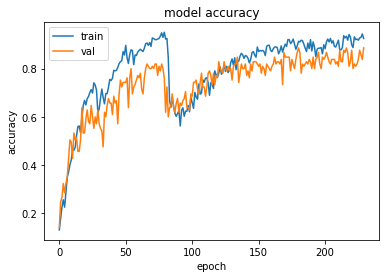

In [436]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('AVSR_English Model_7words accuracy.jpg')
plt.show()

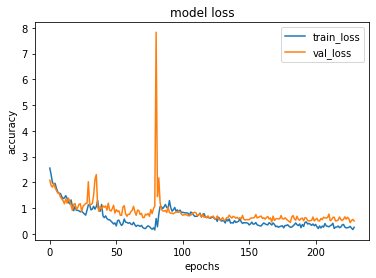

In [438]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.savefig('AVSR_English_Model_7words_Loss.jpg')
plt.show()

In [439]:
predict_prob=model.predict([X_test_audio_array,X_test_array])
predict_classes=np.argmax(predict_prob,axis=1)
predict_classes
score, acc = model.evaluate([X_test_audio_array,X_test_array], Y_test_array)

4/4 [==============================] - 0s 17ms/step - loss: 0.4987 - accuracy: 0.8857


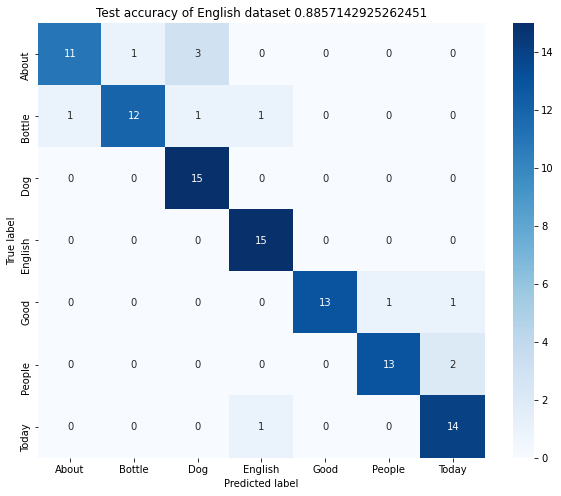

In [441]:
y_val1 = list()
for i in Y_test_array:
    count = 0
    for j in i:
        if( j == 1):
            y_val1.append(count);
        count +=1;

from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
words_list = ['About','Bottle', 'Dog','English', 'Good','People', 'Today']
lb = LabelEncoder()
y_pred1 = lb.fit_transform(predict_classes)
Y_Test1 = lb.fit_transform(y_val1)
cm = confusion_matrix(Y_Test1, y_pred1)
cm_df = pd.DataFrame(cm,index =words_list,columns = words_list)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.title('Test accuracy of English dataset {}'.format(acc))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('AVSR_English_7words_Confusion Matrix.jpg')
plt.show()

In [442]:
from sklearn.metrics import classification_report
y_pred1 = lb.fit_transform(predict_classes)
Y_Test1 = lb.fit_transform(Y_Test1)
print(classification_report(Y_Test1, y_pred1, target_names=words_list))

              precision    recall  f1-score   support

       About       0.92      0.73      0.81        15
      Bottle       0.92      0.80      0.86        15
         Dog       0.79      1.00      0.88        15
     English       0.88      1.00      0.94        15
        Good       1.00      0.87      0.93        15
      People       0.93      0.87      0.90        15
       Today       0.82      0.93      0.87        15

    accuracy                           0.89       105
   macro avg       0.89      0.89      0.88       105
weighted avg       0.89      0.89      0.88       105



In [444]:
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
model1.save('english_model_video_7words_v1.h5')
model.save('avsr_english_7words_v1.h5')